In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
data = np.load("s1_data_std.npy")

In [10]:
len(data)

999

In [9]:
data

array([[[[[ 0.13654423],
          [ 0.17068028],
          [ 0.58031297],
          ...,
          [ 1.6385307 ],
          [ 1.8774832 ],
          [ 1.3654423 ]],

         [[ 0.27308846],
          [ 0.10240817],
          [ 0.10240817],
          ...,
          [ 1.5361226 ],
          [ 1.4678504 ],
          [ 0.8875375 ]],

         [[ 0.44376874],
          [ 0.23895241],
          [ 8.670559  ],
          ...,
          [ 1.3995783 ],
          [ 1.0240817 ],
          [ 0.7168572 ]],

         ...,

         [[ 0.        ],
          [ 0.03413606],
          [ 0.03413606],
          ...,
          [ 0.81926537],
          [ 0.81926537],
          [ 0.81926537]],

         [[ 8.704695  ],
          [ 0.13654423],
          [ 0.37549663],
          ...,
          [ 1.2630341 ],
          [ 1.0240817 ],
          [ 0.8534014 ]],

         [[ 8.704695  ],
          [ 0.3072245 ],
          [ 0.40963268],
          ...,
          [ 2.0140274 ],
          [ 1.809211  ],
          

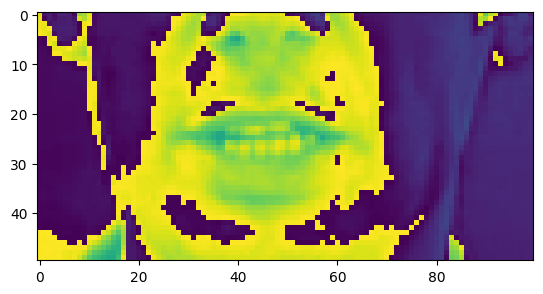

In [7]:
plt.imshow(data[4][40])

In [8]:
tokens = np.load("s1_tokens.npy")
tokens

array([[ 2,  9, 14, ...,  0,  0,  0],
       [ 2,  9, 14, ...,  0,  0,  0],
       [ 2,  9, 14, ...,  0,  0,  0],
       ...,
       [19,  5, 20, ...,  0,  0,  0],
       [19,  5, 20, ...,  0,  0,  0],
       [19,  5, 20, ...,  0,  0,  0]], dtype=int64)

In [11]:
len(tokens)

999